In [12]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

In [2]:
#导入数据
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.layers import Conv1D,GlobalMaxPool1D
import glob
import os
from random import shuffle

# def pre_process_data(filepath):
#     positive_path = os.path.join(filepath,'pos')
#     negative_path = os.path.join(filepath,'neg')
#     pos_label = 1
#     neg_label = 0
#     dataset = []
#     for filename in glob.glob(os.path.join(positive_path,'*.txt')):
#         with open(filename,'r',encoding='utf-8') as f:
#             dataset.append((pos_label,f.read()))
#     for filename in glob.glob(os.path.join(negative_path,'*.txt')):
#         with open(filename,'r',encoding='utf-8') as f:
#             dataset.append((neg_label,f.read()))
#     shuffle(dataset)
#     return dataset

def pre_process_data(filepath):
    positive_path = os.path.join(filepath,'pos')
    negative_path = os.path.join(filepath,'neg')
    pos_label = 1
    neg_label = 0
    dataset = []
    for filename in glob.glob(os.path.join(positive_path,'*.txt')):
        dataset.append((pos_label,filename))
    for filename in glob.glob(os.path.join(negative_path,'*.txt')):
        dataset.append((neg_label,filename))
    shuffle(dataset)
    return dataset

dataset = pre_process_data(r'D:\迅雷下载\nlpia-master-源代码及下载资源\dataset\7.4.1- IMDB电影评论数据集\aclImdb\train')
dataset[0:5]

[(0,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\neg\\12091_3.txt'),
 (0,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\neg\\771_4.txt'),
 (0,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\neg\\4781_1.txt'),
 (1,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\pos\\1647_10.txt'),
 (1,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\pos\\11503_10.txt')]

In [3]:
#向量化及分词器
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors
from nlpia.loaders import get_data

# word_vector = get_data('w2v',limit=200000)     #可以使用但是消耗太多内存
word_vector=KeyedVectors.load_word2vec_format(r'D:\迅雷下载\GoogleNews-vectors-negative300.bin.gz',binary=True)

split_point=int(len(dataset)*0.8)
trainData=dataset[:split_point]
testData=dataset[split_point:]
tokenizer=TreebankWordTokenizer()


C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version.

NameError: name 'dataset' is not defined

In [4]:
# def tokenize_and_vectorizer(dataset):
#     tokenizer = TreebankWordTokenizer()
#     vectorized_data = []
#     for sample in dataset:
#         tokens = tokenizer.tokenize(sample[1])
#         sample_vec = []
#         for token in tokens:
#             try:
#                 sample_vec.append(word_vector[token])
#             except KeyError:
#                 pass    #没有token在这200000词当中
#         vectorized_data.append(sample_vec)
#     return vectorized_data

def token_and_vectorize(filename,tokenizers):       #将句子转换为词向量
    sample_vec=[]
    with open(filename,'r',encoding='utf-8') as f:
        tokens=tokenizer.tokenize(f.read())
        for token in tokens:
            try:
                sample_vec.append(word_vector[token])
            except:
                pass
    return sample_vec


def collect_expected(dataset):       #得到标签
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return expected

def pad_trunc(data,maxlen=400):      #将每个句子的词向量长度规范到400
    zero_vector=[]
    for _ in range(len(data[0])):
        zero_vector.append(0.0)
    if len(data)>maxlen:
        temp=data[:maxlen]
    elif len(data)<maxlen:
        temp=data
        additional_elems=maxlen-len(data)
        for _ in range(additional_elems):
            temp.append(zero_vector)
    else:
        temp=data
    return temp



In [5]:
def data_generator(data_store,tokenizers,batchsize=32,maxlen=400,embedding_dims=300):
    X,Y=[],[]
    while True:
        for i in range(len(data_store)):
            if (i % batchsize==0 and X and Y) or (i==len(data_store)):
                X=np.reshape(X,(len(X),maxlen,embedding_dims))
                Y=np.array(Y)
                yield X,Y
                X,Y=[],[]
            x,y=data_store[i][1],data_store[i][0]
            x=pad_trunc(token_and_vectorize(x,tokenizers),maxlen=maxlen)    
            X.append(x)
            Y.append(y)

In [8]:
import math

#设置CNN参数
maxlen = 400
batch_size = 32 
embedding_dim = 300    #词向量长度
filters = 250
kernel_size = 3
hidden_dim = 250
epochs = 2

model=Sequential()
model.add(Conv1D(filters,kernel_size,padding='valid',activation='relu',strides=1,input_shape=(maxlen,embedding_dim)))  #卷积核尺寸为3*300
model.add(GlobalMaxPool1D())
model.add(Dense(hidden_dim))
model.add(Dropout(0.2))
model.add(Activation('relu'))
#输出层
model.add(Dense(1))
model.add(Activation('sigmoid'))
#编译
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

X_test=data_generator(testData,tokenizer,batchsize=batch_size,maxlen=maxlen)

trainlen = len(trainData)
testlen = len(testData)

history=model.fit(data_generator(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=3,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 398, 250)          225250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                

<AxesSubplot:>

(0.0, 1.0)

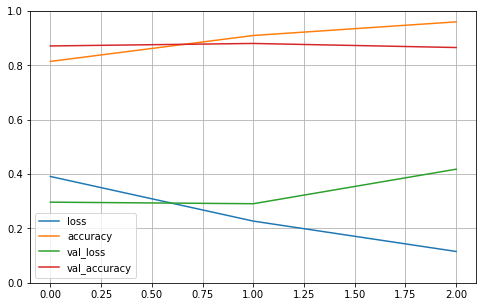

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# 保存模型的方式——new

In [10]:
model_structure = model.to_json()
with open(r'D:\深度学习模型\nlp_7.4_cnn_model.json','w')as f:
    f.write(model_structure)
model.save_weights(r'D:\深度学习模型\nlp_7.4_cnn_weight.h5')

2290

In [2]:
#在流水线中使用模型
from keras.models import model_from_json

with open(r'D:\深度学习模型\nlp_7.4_cnn_model.json','r')as f:
    json_string = f.read()
model = model_from_json(json_string)
model.load_weights(r'D:\深度学习模型\nlp_7.4_cnn_weight.h5')

# 测试样本

In [13]:
from nltk.tokenize import TreebankWordTokenizer
import numpy as np
tokenizer = TreebankWordTokenizer()
file1 = r'D:\迅雷下载\nlpia-master-源代码及下载资源\dataset\7.4.1- IMDB电影评论数据集\aclImdb\test\pos\5_7.txt'
vec_list = token_and_vectorize(file1,tokenizer)

def reshape_400(list):
    zero_list = [0.0 for i in range(len(list[0]))]
    if len(list)>400:
        temp = list[:400]
    elif len(list)<400:
        temp = list
        for i in range(400-len(list)):
            temp.append(zero_list)
    else:
        temp = list
    return temp
test_vec_list = reshape_400(vec_list)

test_vec = np.reshape(test_vec_list,(1,400,300))

model.predict(test_vec)
model.predict_classes(test_vec)    #     pos_label = 1 ,neg_label = 0

array([[0.81582594]], dtype=float32)

array([[1]])